In [1]:
#import statements

import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg
import math
# import pandas as pd
import scipy.interpolate
import time
import copy
#import astropy.io
#import astropy.table
#import glob
import shutil
import netCDF4


In [2]:
#timing the project
start_time = time.time()

In [3]:
#important variable names
raw_folder = '7002_raw'
processed_folder = '7002_processed'

In [4]:
def printImage (image_name, param_dpi = 100, param_width = 20, param_length = 12):

    '''
    This function prints a given image

    :param image_name: the complete directory of the image file
    :param param_dpi:
    :param param_width:
    :param param_length:
    :return: None, simply prints the image
    '''

    #getting the image file
    image_file = image_name
    fig, ax = plt.subplots()
    fig.set_size_inches(param_width, param_length)
    fig.set_dpi(param_dpi)
    image_data = fits.getdata(image_file)

    #getting and displaying coordinates from table

    hdul = fits.open(image_file)

    #if the file has the table matix I created, use table values label axis
    drawP1 = len(hdul)>1 and len(hdul[1].data) == 2
    if drawP1:
        data = hdul[1].data # assuming the first extension is a table
        plt.imshow(image_data, cmap='gray', extent=[data[0][0],data[1][0],data[0][1], data[1][1]])
        plt.colorbar()
        print(image_file)
    else:
        plt.imshow(image_data, cmap='gray')
        plt.colorbar()
        print(image_file)

    hdul.close()


In [5]:
#the next two hidden cells display the original images, for troubleshooting
#printImage(image_file_l3b, param_width = 10, param_length = 6)
#printImage(image_file_l2b, param_width = 5, param_length = 4)


In [6]:
def storeImage (image, file_name, lons = None, lats = None):
    """
    Stores the image into a fits file

    :param image: display array
    :param file_name: name of the file with a '.fits' ending
    :param lons: stretched lons array
    :param lats: stretched lats array
    :return: None, stores the image into a file
    """

    #HDU of intensity vals
    hdu_image = fits.PrimaryHDU(image)

    if (lons is not None) or (lats is not None):
        #mins and maxes
        lon_min = lons.min()
        lon_max = lons.max()
        lat_min = lats.min()
        lat_max = lats.max()

        #HDU of a table, of x-min, x-max, y-min, y-max
        c1 = fits.Column(name='lon', array=np.array([lon_min, lon_max]), format='E')
        c2 = fits.Column(name='lat', array=np.array([lat_min, lat_max]), format='E')
        table_hdu = fits.BinTableHDU.from_columns([c1, c2])

        final_hdu = fits.HDUList([hdu_image, table_hdu])
        final_hdu.writeto(file_name, overwrite = True)
    else:
        final_hdu = fits.HDUList([hdu_image])
        final_hdu.writeto(file_name, overwrite = True)


In [7]:
#function that maps the image
def mapping_func(longitude, lattitude, intensity_vals):
    '''
    maps the image into a Minneart projection

    :param longitude: longitude vector (1D array)
    :param lattitude: lattitude vector (1D array)
    :param intensity_vals: intensity vector (1D array)
    :return: xi: evenly spaced x values between max and min ///
             yi: evenly spaced x values between max and min ///
             zv: interpolated brightness values for these x and y points
    '''

    #mapped regular image
    A = np.vstack((longitude, lattitude, intensity_vals)).T #change the name of flat_x to determine what king of image

    rm_row_ix = np.isnan(A[:,0]) | np.isnan(A[:,1]) | np.isnan(A[:,2]) #remove nan data
    B = A[~rm_row_ix,:]

    x = B[:,0]
    y = B[:,1]
    z = B[:,2]

    # Generates evenly spaced out numbers between xmin and xmax
    xi  = np.linspace(x.min(), x.max(), 1800)
    yi   = np.linspace(y.min(), y.max(), 1800)

    #pairs every x coordinate with y coordinate, creating a 'grid'
    xv, yv = np.meshgrid(xi, yi)

    # Interpolate; what would the z values be for these x and y values?
    try:
        zv = scipy.interpolate.griddata((x, y), z, (xv, yv), method='linear') #this is the final file
    except Exception as e:
        print(e)
        raise(e)

    return zv, xi, yi

In [8]:
def process_file (netCDF_directory):

    #opening the files
    try:
        nc = netCDF4.Dataset(netCDF_directory)

        #file name generation
        dirname_l3 = os.path.basename(netCDF_directory)
        name_list = dirname_l3.split("_")
        name = name_list[0] + name_list[1] + name_list[2] + name_list[3]


        long_data = nc.variables["lon"][0]              #longitude
        lat_data = nc.variables["lat"] [0]                 #lattitude
        incidence_data = nc.variables["inangle"][0]       #solar incidence angle: angle between suns ray's and normal of the surface
        emission_data = nc.variables["emangle"][0]       #emission angle: angle between telescope and normal of the surface
        # solar_time = l3_data['S_SOLLON'].data
        image_data = nc.variables["radiance"][0]         #brightness data
        distance = nc.variables["S_DISTAV"][0]
        phangle = nc.variables["phangle"][0]
        sub_spacecraft_lon = nc.variables["S_SSCLON"][0]


        #turning a masked array into a normal array, with missing values as NANS
        np.ma.set_fill_value(long_data, 0)
        np.ma.set_fill_value(lat_data, 0)
        np.ma.set_fill_value(incidence_data, 0)
        np.ma.set_fill_value(emission_data, 0)
        np.ma.set_fill_value(image_data, 0)

        lon_mask = np.ma.getmask(long_data)
        lon = np.ma.getdata(long_data)
        lon[lon_mask] = np.nan

        lat_mask = np.ma.getmask(lat_data)
        lat = np.ma.getdata(lat_data)
        lat[lat_mask] = np.nan

        incidence_mask = np.ma.getmask(incidence_data)
        incidence= np.ma.getdata(incidence_data)
        incidence[incidence_mask] = np.nan

        emission_mask = np.ma.getmask(emission_data)
        emission = np.ma.getdata(emission_data)
        emission[emission_mask] = np.nan

        image_mask = np.ma.getmask(image_data)
        image = np.ma.getdata(image_data)
        image[image_mask] = np.nan

        #when summing, dont use images greater than 120 degrees: skip those, also make sure that the spacecraft is far away enough
        #use the masked array to set the mask to 0, when averaging : look at the code you recieved this morining

            #finding mu and mu0
        mu = np.cos(np.radians(emission))               #mu for every point in the image
        mu_zero = np.cos(np.radians(incidence))         #mu_0 for every point in the image
        mu_lim = np.cos(np.radians(85))               #sets limit for zenith angles higher than 90, becase cos(pi/2) = 0

        middle = mu[100]
        ele = np.linspace(0, 1023, 1024)


        #consider changing the mu lim value to a lower number, like 88 87 degrees, play around with that

        #creating masks
        lat_mask = (-90 <= lat) & (lat <= 90)
        mu_mask = (mu > mu_lim) & (mu_zero > mu_lim) & lat_mask
        xvals = np.log(mu[mu_mask] * mu_zero[mu_mask])
        yvals = np.log(image[mu_mask] * mu[mu_mask])


        #linear regression to find I and k, problem with outliers: consider
        Z = np.vstack([xvals, np.ones(len(xvals))]).T
        k, i = numpy.linalg.lstsq(Z, yvals, rcond=None)[0]
        a0 = math.exp(i)

        #creating the normalized image
        intensity = image * 0                           #creating a zero matrix the size of 'image'
        intensity[mu_mask] = (a0 * ((mu[mu_mask] * mu_zero[mu_mask]) ** k)) / (mu[mu_mask])
        intensity[~mu_mask] = 0

        #residuals
        residuals = abs(image - intensity)
        #fix this
        ratio = image/(intensity+.00001)


        #make a copy of the image, and create the harsh border
        copy_image = copy.deepcopy(image) #copy of the image
        copy_image[~mu_mask] = 0          #setting any value outside of the mask to 0

        #harsh resid
        harsh_resid = abs(copy_image - intensity)

        #harsh ratio
        harsh_ratio = copy_image/(intensity+.00001)



        # #storing file not used for now
        # storeImage(intensity, name + "_normalized.fits")
        # storeImage(harsh_resid, name + "_residuals.fits")
        # storeImage(harsh_ratio, name + "_ratio.fits")

        #mapping the image
        flat_lon = lon.ravel()                    #turning the array into a single-dimensional vector
        flat_lat = lat.ravel()
        flat_image = image.ravel()
        flat_intensity = intensity.ravel()
        flat_residual = harsh_resid.ravel()
        flat_ratio = harsh_ratio.ravel()
        lat_long_list = [(flat_lon[i], flat_lat[i]) for i in range(len(flat_lon))]
        lat_long_array = np.array(lat_long_list)

        #resid and ratio
        map_original, map_original_image_lon, map_original_image_lat = mapping_func(flat_lon, flat_lat, flat_image)
        map_norm, map_normalized_image_lon, map_normalized_image_lat = mapping_func(flat_lon, flat_lat, flat_intensity)
        map_resid, map_resid_lon, map_resid_lat = mapping_func(flat_lon, flat_lat, flat_residual)
        map_ratio, map_ratio_lon, map_ratio_lat = mapping_func(flat_lon, flat_lat, flat_ratio)

        #keeping track of non-zero pixels, then sum both arrays when averaging
        map_norm_track = copy.deepcopy(map_norm)
        map_norm_track[map_norm_track > 0] = 1

        # #storing mapped images, only using the ratio for now
        # storeImage(map_original, name + "_map_original.fits", lons = map_original_image_lon, lats= map_original_image_lat)
        # storeImage(map_norm, name + "_map_norm.fits", lons = map_normalized_image_lon, lats= map_normalized_image_lat)
        # storeImage(map_resid,name +  "_map_resid.fits", lons = map_resid_lon, lats= map_resid_lat)
        storeImage(map_ratio,name +  "_map_ratio.fits", lons = map_ratio_lon, lats= map_ratio_lat)

        storage_name = name +  "_map_ratio.fits"
        store_file(storage_name)

    except Exception as e:
        print(e)
        raise e

In [9]:
def store_file(file_name):
    shutil.move('/Users/sashaignatiev/Documents/Venus/' + raw_folder + "/" + file_name, '/Users/sashaignatiev/Documents/Venus/' + processed_folder)

In [10]:
def process_orbit(folder_name):
    os.chdir(folder_name)
    onlyfiles = [f for f in os.listdir()]
    successful_files = 0
    failed_files = 0
    for file in onlyfiles:
        try:
            process_file(file)
            successful_files += 1
        except Exception as e:
            failed_files += 1
    print(str(successful_files), str(failed_files))
    os.chdir("..")

In [11]:
def prep_files_for_summing(folder_name):
    os.chdir(folder_name)
    onlyfiles = [f for f in os.listdir()]
    return onlyfiles
    os.chdir("..")

To do:
1. create a script that gets the phase angle from every image, you see the whole planet when phase angle is 0
2. map the averaged image for longitude and lattitude
3. get sub spacecraft longitude from each image, put that in the center of the array, to map each image from the sub-spacecraft longitude
4. create a method that shifts the image so that the sub-spacecraft longitude is always underneath the spacecraft

In [12]:
def avg_using_cube():


    #opening the folder
    files = prep_files_for_summing(processed_folder)
    print("this line runs")
    #counting the files
    numfiles = len(files)
    numfiles = 10

    #opening the first file and extracting the hdu
    f = files[0]
    try:
        hdu = fits.open(f)
    except Exception as e:
        print("first file could not be openend :(")
        raise e

    #beginning the sum array by extracting the table from the first hdu
    dimensions = hdu[0].data

    #creating the sum array and the count array
    sum = np.zeros_like(dimensions)

    # Initialize # of pixels summed array
    numtot = copy.deepcopy(sum)

    # initialize the sum of squared brightness to calculate standard deviation at the end
    sumsqr = sum

    #initialzing loop vars
    j = 0
    failed_counter = 0
    success_counter = 0

    cube_matrix = np.zeros((1800, 1800, numfiles))

    #going through files and summing each one
    while j < numfiles:

        print(f"working on the {j} file")

        #opening each file and extracting the array
        f = files[j]
        try:
            hdu = fits.open(f)
            success_counter += 1
        except:
            failed_counter += 1

        add = hdu[0].data
        cube_matrix[:,:,j] = add
        j+=1

    cube_matrix[cube_matrix==0] = np.nan

    avg = np.nanmean(cube_matrix, axis = 2)



    split_name = processed_folder.split("_")
    name = split_name[0]

    storeImage(avg, name +  "_avg_" + numtot +"_cube.fits")




In [ ]:
def view_ssl():
  prep_files_for_summing()  # rename this function to get_processed_list of smthn


In [13]:
def avg_using_linalg():

    #opening the folder
    files = prep_files_for_summing(processed_folder)
    print("this line runs")
    #counting the files
    numfiles = len(files)

    #opening the first file and extracting the hdu
    f = files[0]

    try:
        hdu = fits.open(f)
    except Exception as e:
        print("first file could not be openend :(")
        raise e

    #extracting longitude and lattitude values
    lat_long_values = hdu[1].data

    lon_min = lat_long_values[0][0]
    lat_min =lat_long_values[0][1]
    lon_max = lat_long_values[1][0]
    lat_max = lat_long_values[0][0]

    lons = np.array([lon_min, lon_max])
    lats = np.array([lat_min, lat_max])

    #beginning the sum array by extracting the table from the first hdu
    dimensions = hdu[0].data

    #creating the sum array and the count array
    sum = np.zeros_like(dimensions)

    # Initialize # of pixels summed array
    numtot = copy.deepcopy(sum)

    #initialzing loop vars
    j = 0
    failed_counter = 0
    success_counter = 0

    #going through files and summing each one
    while j < numfiles:

        print(f"working on the {j} file")

        #opening each file and extracting the array
        f = files[j]
        try:
            hdu = fits.open(f)
            success_counter += 1
        except:
            failed_counter += 1
            j+=1
            continue

        add = hdu[0].data
        #addint data and updating vars

        #every nan in add and add_counter converted to 0
        add[np.isnan(add)] = 0
        numadd = copy.deepcopy(add)
        numadd[numadd > 0] = 1

        j+=1

    sum = sum + add  # cumulative sum of pixel brightness
    numtot = numtot + numadd  # cumulative sum of images being summed at each pixel

    avg = np.divide(sum, numtot)

    split_name = processed_folder.split("_")
    name = split_name[0]

    storeImage(avg, name +  "_avg_" + str(numfiles) +"_lin.fits", lons = lons, lats = lats)
    print(failed_counter)


In [14]:
def mat_avg (mat_list):
    sum_mat = np.zeros((3,3))
    count = 0
    for mat in mat_list:
        sum_mat += mat
        count += 1

    average = sum_mat / count
    return average

#
# matrices = []
# a = np.ones((3,3)) #1
# b = np.ones((3,3)) #2
# c = a + b #4
# d = a + b #6
#
# matrices.append(a)
# matrices.append(b)
# matrices.append(c)
# matrices.append(d)
#
# x = mat_avg(matrices)
# print(x)

[[1.5 1.5 1.5]
 [1.5 1.5 1.5]
 [1.5 1.5 1.5]]


In [15]:
def Limayes_code():
    #   Set up the sum and # of pixels averaged arrays using an image.

    files = prep_files_for_summing(processed_folder)
    numfiles = len(files)

    f = netCDF4.Dataset(files[0])  # read a l3 image (1440 x 2880 for uv or 720 x 1440 for lir)
    print(f.variables.keys())

    image = f.variables['btemp']

    sum = image[0]  # initialize the sum array
    sum = np.ma.filled(sum.astype(float), 0)  # Sophie's solution to set nan’s to ‘zero’

    numtot = image[0]  # Initialize # of pixels summed array

    numtot = np.ma.filled(numtot.astype(float), 0)  # Set the nan’s to ‘zero’
    sum[sum > 0] = 0
    numtot[numtot > 0] = 0
    sumsqr = sum  # initialize the sum of squared brightness to calculate standard deviation at the end

    # Then in looping through the images to add and track the  # of pixels being summed:
    j = 0
    while j < numfiles:
        f = netCDF4.Dataset(files[j])
        image = f.variables['btemp']
        add = image[0]
        add = np.ma.filled(add.astype(float), 0)
        j += 1

    numadd = image[0]  # Copy the image data to get non-zero pixels
    numadd = np.ma.filled(numadd.astype(float), 0)  # take account of the nan’s
    numadd[numadd > 0] = 1  # set the valid locations to “1”

    sum = sum + add  # cumulative sum of pixel brightness
    sumsqr = sumsqr + add * add  # sum of squared brightness to calculate standard deviation
    numtot = numtot + numadd  # cumulative sum of images being summed at each pixel


    # After all imagees are summed:

    avg = sum / numtot
    std = np.sqrt(sumsqr / numtot - avg * avg)


    print(avg)
    print(std)



#
# # change width of output array and mesh to have the image go from 0-360
# # or you can use the code that Dr. Limaye sends you
#
# #for each image, create a "track" array with 0 and 1 that has ones where brightness is non-zero
# #when summing the images, sum the normalized image and the 'track' array
# #then when you are averaging, use the 'track' array to keep track of the sum of each pixel


#



In [16]:
avg_using_linalg()

this line runs
working on the 0 file
working on the 1 file
working on the 2 file
working on the 3 file
working on the 4 file
working on the 5 file
working on the 6 file
working on the 7 file
working on the 8 file
working on the 9 file
working on the 10 file
working on the 11 file
working on the 12 file
working on the 13 file
working on the 14 file
working on the 15 file
working on the 16 file
working on the 17 file
working on the 18 file
working on the 19 file
working on the 20 file
working on the 21 file
working on the 22 file
working on the 23 file
working on the 24 file
working on the 25 file
working on the 26 file
working on the 27 file
working on the 28 file
working on the 29 file
working on the 30 file
working on the 31 file
working on the 32 file
working on the 33 file
working on the 34 file
working on the 35 file
working on the 36 file
working on the 37 file
working on the 38 file
working on the 39 file
working on the 40 file
working on the 41 file
working on the 42 file
workin

/var/folders/j7/l7rgct152nn9cmm94tj7s1v40000gn/T/ipykernel_30298/1730025632.py:71: RuntimeWarning: invalid value encountered in true_divide
  avg = np.divide(sum, numtot)


In [17]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 16.595878839492798 seconds ---


uvi20181127030114283_map_ratio.fits


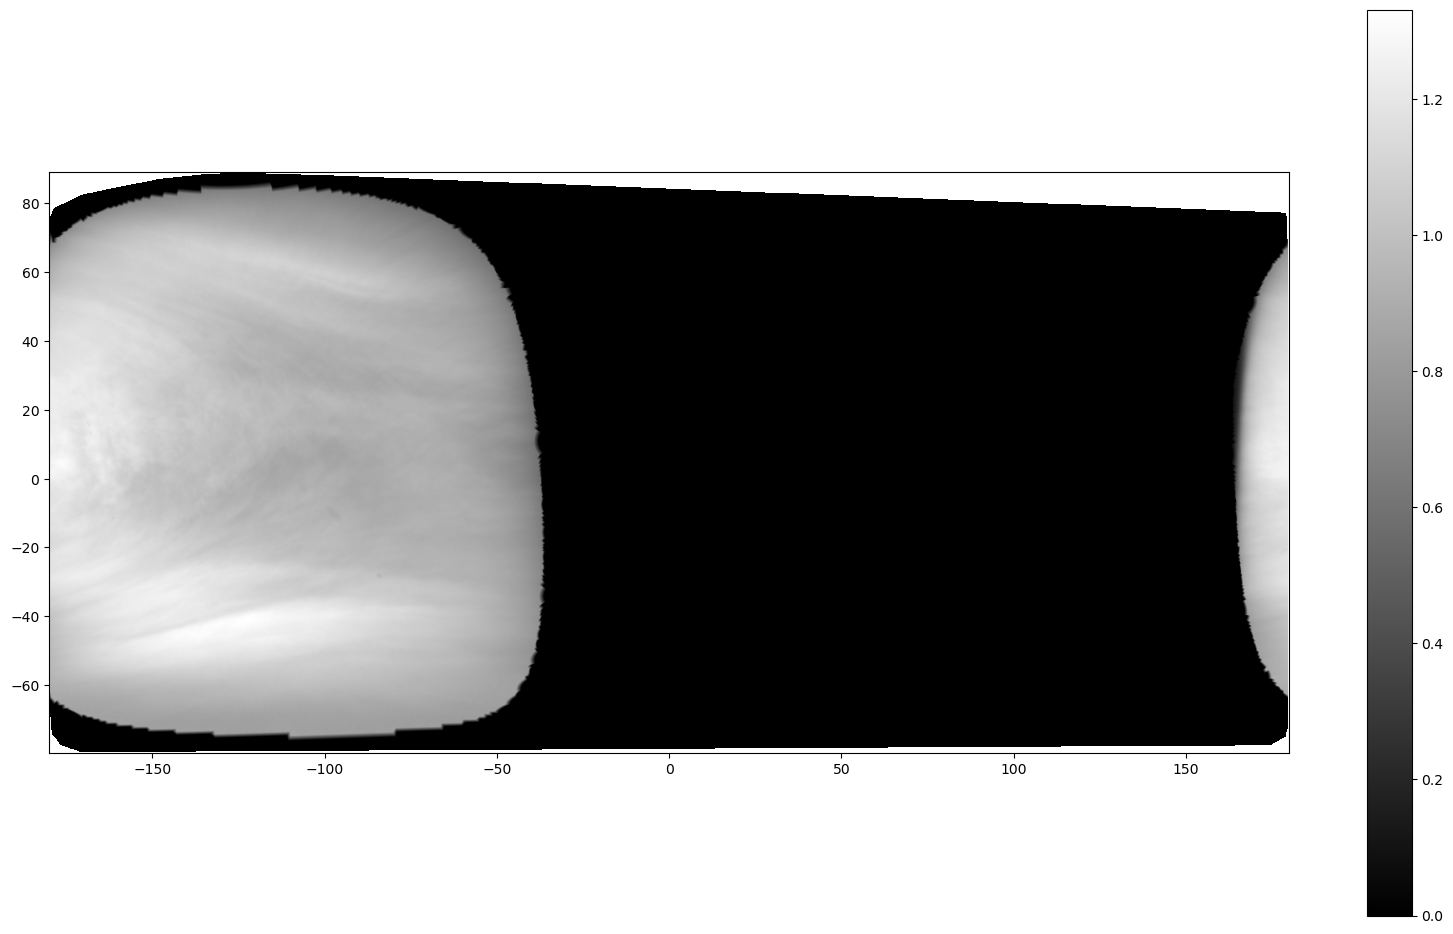

In [22]:
printImage("uvi20181127030114283_map_ratio.fits")

In [ ]:
hdul = fits.open("uvi20181127030114283_map_ratio.fits")
hdul.info()
hdul.close()

In [23]:
os.getcwd()

'/Users/sashaignatiev/Documents/Venus/7002_processed'

In [24]:
os.chdir("..")

In [25]:
os.getcwd()

'/Users/sashaignatiev/Documents/Venus'

In [ ]:
def main(raw_folder, processed_folder, process_orbit = False, average = False):
    if process_orbit == True:
        print("yes")
    if average == True:
        print("yes")

    print("done")
